<a href="https://colab.research.google.com/github/ali-rabiee/Portfolio-Formation/blob/main/Portfolio_Formation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements & Libraries

In [ ]:
!pip3 install Keras
!pip3 install keras-rl
# !pip install tensorflow==1.15
!pip install keras
!pip install keras-rl
!pip install gym
# !pip install pandas
!pip install rl
!pip install keras-rl2
!pip install Callbacks 
!pip install callbacks
!pip install rl.callbacks
!pip install tf-nightly
!pip install yfinance
!pip install minisom

# Google Drive Connection

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
os.chdir('drive/My Drive/Colab Notebooks/DQN')

Mounted at /content/drive/


# Get Data

In [4]:
# Name of 60 Stocks  
stocks = ['CDEV', 'GILD', 'JBLU', 'HBAN','SLB',
          'CS', 'PLUG', 'USB', 'ABBV','CTRA', 'SIRI',
          'SCHW', 'M', 'FCX', 'MO','UAL', 'ET','KGC',
          'NCLH', 'NKE','ERIC', 'ZNGA','PTON',
          'CLF', 'PYPL', 'MRO','CMCSA', 'INFY',
          'SNAP','TSM', 'CSCO', 'FB', 'UBER', 'OXY',
          'JPM', 'GOLD', 'TSLA', 'BABA', 'NLSN','TLRY',
          'AMC', 'VALE', 'DAL', 'TELL','ITUB', 'PCG','AAL',
          'NVDA', 'WFC', 'AMD', 'AAPL', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT']

print(f"Number of Stocks: {len(stocks)}")

Number of Stocks: 59


In [ ]:
from get_stock import get_stock

# Getting Data

start = "2020-05-10"
end = "2022-04-29"

for ticker in stocks:
    # Download datasets
    print(f'### Downloading {ticker}:')
    Hour = get_stock(ticker, start, end, "60m")
    Day = get_stock(ticker, start, end, "1d")
    Week = get_stock(ticker, start, end, "1wk")
    
    # Reset indexes
    Hour.reset_index(drop=True, inplace=True)
    Day.reset_index(drop=True, inplace=True)
    Week.reset_index(drop=True, inplace=True)

    # Save the datasets
    PATH = "datasets/"
    Hour.to_csv(f"{PATH}{ticker}hour.csv")
    Day.to_csv(f"{PATH}{ticker}day.csv")
    Week.to_csv(f"{PATH}{ticker}week.csv")

# Correlation

In [ ]:
from clustering import calculate_correlation, visualize_clusters
import datetime

# Calculate the correlation of time series from the base for last 30 days
base = "2020-10-25"
base = datetime.datetime.strptime(base, '%Y-%m-%d')
numdays = 30
som_x, som_y, win_map, clusters = calculate_correlation(base, numdays)

In [ ]:
lst = [1,2,3,4,5,6]
del lst[1]
lst[1]

3

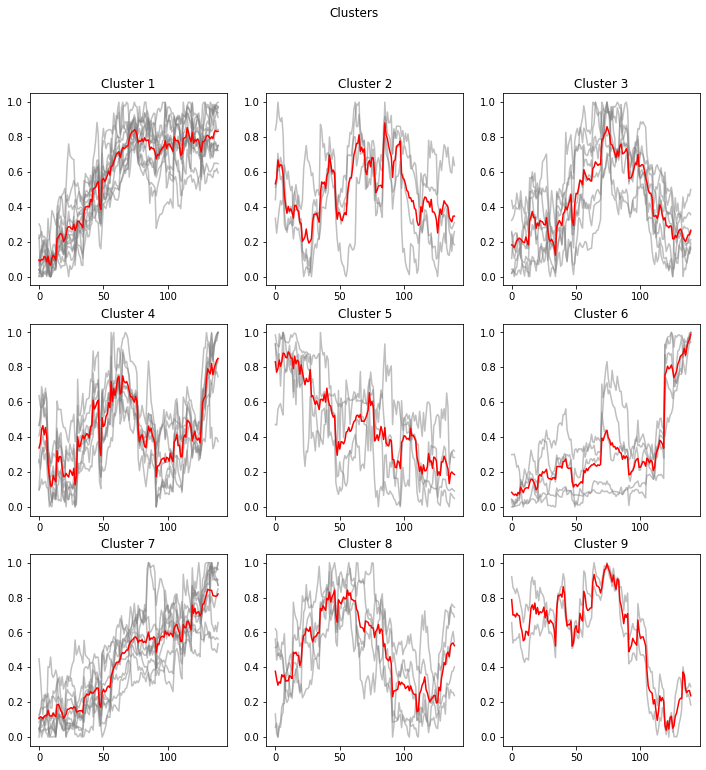

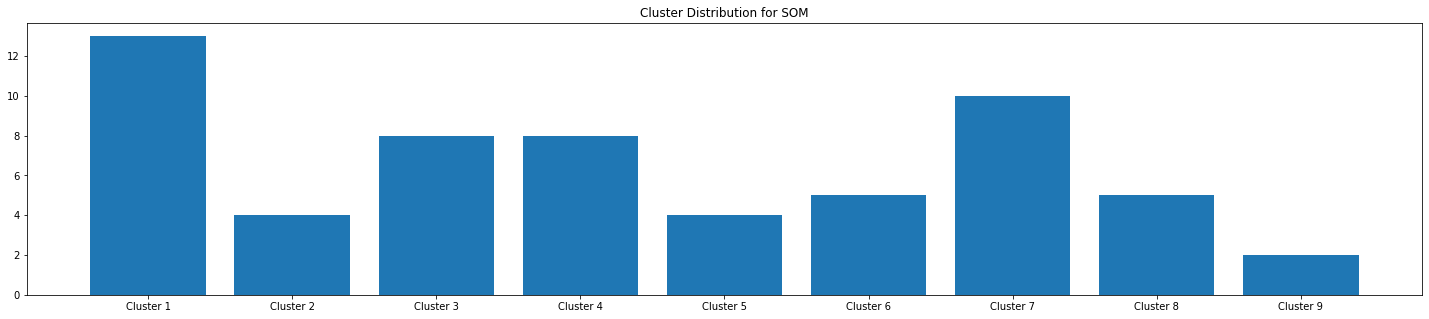

In [ ]:
# Visualization
visualize_clusters(som_x, som_y, win_map)

# Train the DQN Model

The code needs three positional parameters to be correctly executed: \\
python main.py [numberOfActions, isOnlyShort, ensembleFolder]


* To run the FULL agent you need to run: python main.py 3 0 ensembleFolder
* To run the ONLY LONG agent you need to run: python main.py 2 0 ensembleFolder
* To run the ONLY SHORT agent you need to run: python main.py 2 1 ensembleFolder \\
where the paramenter ensembleFolder is used to set the name of the folder in which you'll get your results.

In [7]:
"""This is the class call for the Agent which will perform the experiment"""

#This is the class call for the Agent which will perform the experiment
from deepQTrading import DeepQTrading

#Date library to manipulate time in the source code
import datetime

#Keras library to define the NN to be used
from keras.models import Sequential

#Layers used in the NN considered
from keras.layers import Dense, Activation, Flatten

#Activation Layers used in the source code
from keras.layers.advanced_activations import LeakyReLU, PReLU, ReLU

#Optimizer used in the NN
from keras.optimizers import Adam

#Libraries used for the Agent considered
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy


#Library used for showing the exception in the case of error 
import sys

import pandas as pd
import numpy as np
from evaluation import perc_ensemble, full_ensemble, ensemble

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

'''
There are three actions possible in the stock market
Hold(id 0): do nothing.
Long(id 1): It predicts that the stock market value will raise at the end of the day. 
So, the action performed in this case is buying at the beginning of the day and sell it at the end of the day (aka long).
Short(id 2): It predicts that the stock market value will decrease at the end of the day.
So, the action that must be done is selling at the beginning of the day and buy it at the end of the day (aka short). 
//////////////////////////////////////////////////////////////
The Model is a simple NN considered. It is composed of:
One flatten layer to get 68 dimensional vectors as input
One dense layer with 35 neurons and LeakyRelu activation
One final Dense Layer with the 3 actions considered
the input is 20 observation days from the past, 8 observations from the past week and 
40 observations from the past hours
//////////////////////////////////////////////////////////////
Define the DeepQTrading class with the following parameters:
explorations: 0.2 operations are random, and 100 epochs.
in this case, epochs parameter is used because the Agent acts on daily basis, so its better to repeat the experiments several
times so, its defined that each epoch will work on the data from training, validation and testing.
trainSize: the size of the train data gotten from the dataset, we are setting 5 stock market years, or 1800 days
validationSize: the size of the validation data gotten from dataset, we are setting 6 stock market months, or 180 days
testSize: the size of the testing data gotten from dataset, we are setting 6 stock market months, or 180 days
outputFile: where the results will be written
begin: where the walks will start from. We are defining January 1st of 2010
end: where the walks will finish. We are defining February 22nd of 2019
nOutput:number of walks
'''
# Set Parameters
nb_actions = 2
isOnlyShort = 0
ensembleFolderName = "ensembleFolder"


# Define the model 
model = Sequential()
model.add(Flatten(input_shape=(1, 1, 68)))
model.add(Dense(35, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(nb_actions))
model.add(Activation('linear'))


stocks = ['ERIC', 'ZNGA','PTON',
          'CLF', 'PYPL', 'MRO','CMCSA', 'INFY',
          'SNAP','TSM', 'CSCO', 'FB', 'UBER', 'OXY',
          'JPM', 'GOLD', 'TSLA', 'BABA', 'NLSN','TLRY',
          'AMC', 'VALE', 'DAL', 'TELL','ITUB', 'PCG','AAL',
          'NVDA', 'WFC', 'AMD', 'AAPL', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT']

for ticker in stocks:

    print(f"\n#### Train {ticker} ####\n")
    # Define the DeepQTrading class
    dqt = DeepQTrading(
        ticker=ticker,
        model=model,
        explorations=[(0.2, 1)],
        trainSize=datetime.timedelta(days=30*19),
        validationSize=datetime.timedelta(days=30*1),
        testSize=datetime.timedelta(days=30*1),
        outputFile="Output/csv/walks/walks",
        begin=datetime.datetime(2020, 6, 30, 0, 0, 0, 0),
        end=datetime.datetime(2022, 4, 1, 0, 0, 0, 0),
        nbActions=nb_actions,
        isOnlyShort=isOnlyShort,
        ensembleFolderName=ensembleFolderName
        )
    numWalks = dqt.run()
    dqt.end()

    # Preparing and saving the results
    numDel = 0
    for j in range(0, numWalks):

        df_test = pd.read_csv("./Output/ensemble/ensembleFolder/walk"+str(j)+f"ensemble_test_{ticker}.csv", index_col='Date')
        df_valid = pd.read_csv("./Output/ensemble/ensembleFolder/walk"+str(j)+f"ensemble_valid_{ticker}.csv", index_col='Date')

        for deleted in range(1, numDel):
            del df_test['iteration'+str(deleted)]
            del df_valid['iteration'+str(deleted)]

        if j == 0:
            fulldf_test = perc_ensemble(df_test)
            fulldf_valid = perc_ensemble(df_valid)

        else:
            fulldf_test = fulldf_test.append(perc_ensemble(df_test))
            fulldf_valid = fulldf_valid.append(perc_ensemble(df_valid))


    metrics_test = ensemble(numWalks, ticker, data_type='test', numDel=0)
    metrics_valid = ensemble(numWalks, ticker, data_type='valid', numDel=0)

    method = "short" if isOnlyShort == 1 else "long"
    
    # Save Predictions
    PATH = "./Output/results/predictions/"
    fulldf_test.to_csv(f"{PATH}{ticker}_{method}_preds_test.csv")
    fulldf_valid.to_csv(f"{PATH}{ticker}_{method}_preds_valid.csv")
    
    # Save metrics
    PATH = "./Output/results/metrics/"
    metrics_test.to_csv(f"{PATH}{ticker}_{method}_metrics_test.csv")
    metrics_valid.to_csv(f"{PATH}{ticker}_{method}_metrics_valid.csv")


#### Train ERIC ####



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Resetted: episode 390; Index 2749 over the limit (2749)
0 TRAIN:  acc: 0.5769230769230769 cov: 0.45614035087719296 rew: 0.2609499446550557
Resetted: episode 17; Index 146 over the limit (146)
0 VALID:  acc: 0.25 cov: 0.16666666666666666 rew: -0.01569957190479929
Resetted: episode 18; Index 153 over the limit (153)
0 TEST:  acc: 0.5555555555555556 cov: 0.375 rew: 0.04752359021613812
 
END

#### Train ZNGA ####

Resetted: episode 390; Index 2749 over the limit (2749)
0 TRAIN:  acc: 0.5384615384615384 cov: 0.4276315789473684 rew: 0.39747785806421804
Resetted: episode 17; Index 146 over the limit (146)
0 VALID:  acc: 0.6 cov: 0.20833333333333334 rew: 0.011662093571416711
Resetted: episode 18; Index 153 over the limit (153)
0 TEST:  acc: 0.25 cov: 0.16666666666666666 rew: -0.004399614366653776
 
END

#### Train PTON ####

Resetted: episode 390; Index 2749 over the limit (2749)
0 TRAIN:  acc: 0.5381679389312977 cov: 0.5745614035087719 rew: 0.9227246389572742
Resetted: episode 17; Index 146 o

In [ ]:
res = ensemble(numWalks=numwalks, ticker=stocks[0], data_type='test', numDel=0)
res

,Iteration,Reward%,#Wins,#Losses,Dollars,Coverage,Accuracy
0,0,0.02,9,7,8.0,0.76,0.56
1,1,-0.06,7,9,-20.5,0.76,0.44
2,2,0.18,10,4,62.5,0.64,0.71
3,3,-0.02,4,5,-7.5,0.45,0.44
4,4,-0.06,1,7,-18.0,0.36,0.12
5,5,-0.03,7,7,-8.5,0.64,0.5
6,6,-0.0,7,9,-0.5,0.76,0.44
7,7,0.11,10,3,35.5,0.62,0.77
8,8,-0.02,4,8,-4.5,0.6,0.33
9,9,-0.03,4,6,-8.5,0.53,0.4


# Portfolio Formation

In [ ]:
ZNGA_short_preds_valid

In [ ]:
method = "long"
data_type = "test"

# Date of the preds
preds = pd.read_csv(f"./Output/results/predictions/{ticker}_{method}_{data_type}.csv")
Date = preds["Date"].to_list()

for date in Date:
    profitable_stocks = []
    for ticker in stocks:
        # Read Predictions
        preds = pd.read_csv(f"./Output/results/predictions/{ticker}_{method}_{data_type}.csv")
        if preds[date] != 0:
            profitable_stocks.append(ticker)




# Trading

In [ ]:
from Trading_Metrics import trade, metrics


# Load the Decisions
actions_long = pd.read_csv("resultEnsembleTest_Long.csv")
actions_short = pd.read_csv("resultEnsembleTest_Short.csv")
df = pd.read_csv("datasets/aaplDay.csv")
# Drop the useless columns
# df = df.reindex(columns = ['Date', 'Open', 'Close'])